### aim: 

### date: 

In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [13]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [14]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

In [15]:
def make_yearfiles_ukesm(yrst, yren, tscen, sig = False):
    #print(f'SCENARIO {tscen}')
    dslist = []
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear/'
    
    for y in range(yrst,yren):
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']
        try:
            if sig:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_mocsig.nc')
            else:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_moc.nc')
            dslist.append(td[0])
            if (len(td) != 1):
                print(f'SCENARIO {tscen}, {y}, something missing')

        except:
            pass

    return dslist

In [16]:
mocf = (make_yearfiles_ukesm(1950, 2100, '1A', sig = True))



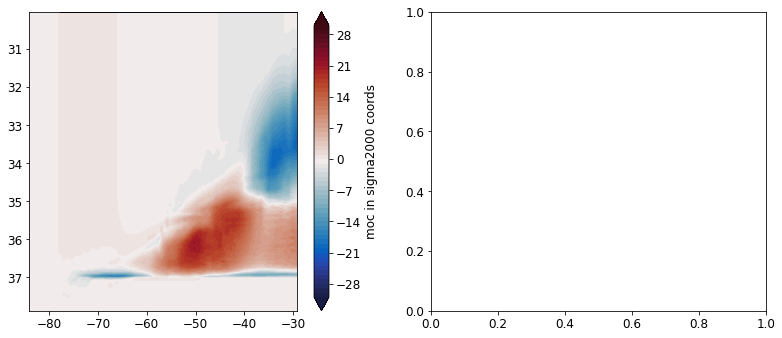

In [17]:
def plot_mocsig(ind, mocfil, vmin = -31, vmax = 31):
    w = axs[ind].contourf(mocfil.latV, mocfil.sigma2000, mocfil.values, np.arange(vmin, vmax, 1), cmap = cm.balance, extend = "both")
    plt.colorbar(w, ax = axs[ind], label = 'moc in sigma2000 coords')
    # print(mocfil.sigma2000)
    axs[ind].invert_yaxis()
    
def get_mean_mocsig(mocf):
    tdat = xr.open_mfdataset(mocf)
    mn = tdat.dmoc2000.isel(latV=slice(0,141)).mean(dim = ['time_counter'])

    return mn

mn = get_mean_mocsig(mocf[0])


fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
plot_mocsig(0,mn)


In [18]:
extract = False

if extract:

    def make_mocsig_nc(yr,tscen):

        tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT/'
        savenam_seas = f'{tdir}/seas_OT_{yr}_{tscen}.nc'
        print(savenam_seas)

        mocf = (make_yearfiles_ukesm(yr, yr+1, tscen, sig = True))
        t = xr.open_dataset(mocf[0])
        times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='MS',closed='left')
        times2 = [times[0], times[3], times[6], times[9]] 
        times3 = pd.to_datetime(times2)

        DJF_mn = t.isel(latV=slice(0,141)).sel(time_counter=(t['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean()
        MAM_mn = t.isel(latV=slice(0,141)).sel(time_counter=(t['time_counter.season'] == 'MAM')).\
        groupby('time_counter.year').mean()
        JJA_mn = t.isel(latV=slice(0,141)).sel(time_counter=(t['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean()
        SON_mn = t.isel(latV=slice(0,141)).sel(time_counter=(t['time_counter.season'] == 'SON')).\
        groupby('time_counter.year').mean()
        yr_mn = t.isel(latV=slice(0,141)).\
        groupby('time_counter.year').mean()

        max_OT = np.zeros(4)
        lat_OT = np.zeros(4)
        sigma2000_OT = np.zeros(4)

        ars = [DJF_mn, MAM_mn, JJA_mn, SON_mn]

        for m in range(0,4):

            t = ars[m]
            t2 = t.dmoc2000.isel(latV=slice(0,141))
            w = t2.where(t2==t2.max(), drop=True).squeeze()

            max_OT[m] = w.values
            lat_OT[m] = w.latV
            sigma2000_OT[m] = w.sigma2000


        t = yr_mn
        t2 = t.dmoc2000.isel(latV=slice(0,141))
        w = t2.where(t2==t2.max(), drop=True).squeeze()

        ### this is a stupid way to do it but i can't get it to be of dimension 1 so
        max_OT_yr = np.zeros(4)
        lat_OT_yr = np.zeros(4)
        sigma2000_OT_yr = np.zeros(4)

        max_OT_yr[:] = w.values
        lat_OT_yr[:] = w.latV
        sigma2000_OT_yr[:] = w.sigma2000



        savenam = savenam_seas
        data_vars = {
            'max_OT':(['time_counter'], max_OT, {'units': 'Sv',}),
            'lat_OT':(['time_counter'], lat_OT, {'units': 'deg',}),
            'sigma2000_OT':(['time_counter'], sigma2000_OT, {'units': 'sigma2000',}),
            'max_OT_yr':(['time_counter'], max_OT_yr, {'units': 'Sv',}),
            'lat_OT_yr':(['time_counter'], lat_OT_yr, {'units': 'deg',}),
            'sigma2000_OT_yr':(['time_counter'], sigma2000_OT_yr, {'units': 'sigma2000',}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times3),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/OT.ipynb',
        'desc': 'where and when does maximum overturning occur'
        }
        ds_seas = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds_seas.to_netcdf(savenam)

        return ds_seas

    scen = ['1A','1B','2A','2B','3A','3B']
    for s in range(0,6):
        tscen = scen[s]
        for yr in range(1950,2100):

            ds_seas = make_mocsig_nc(yr,tscen)



In [19]:


def make_yearlist(yrst, yrend, tscen, \
                  tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'{tdir}/seas_OT_{yr}_{tscen}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

OT_1A = xr.open_mfdataset(make_yearlist(1950,2099,'1A'))
OT_2A = xr.open_mfdataset(make_yearlist(1950,2099,'2A'))
OT_3A = xr.open_mfdataset(make_yearlist(1950,2099,'3A'))
OT_1B = xr.open_mfdataset(make_yearlist(1950,2099,'1B'))
OT_2B = xr.open_mfdataset(make_yearlist(1950,2099,'2B'))
OT_3B = xr.open_mfdataset(make_yearlist(1950,2099,'3B'))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


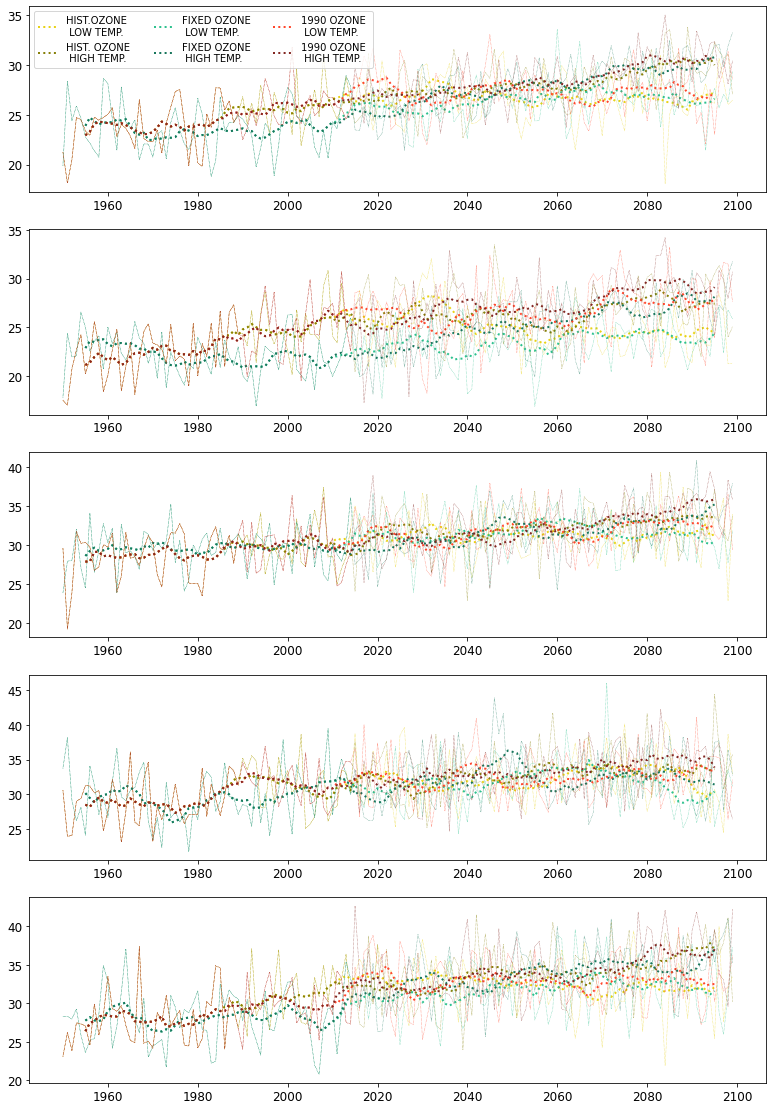

In [20]:
models = [OT_1A,OT_1B,OT_2A,OT_2B,OT_3A,OT_3B,\
         ]
scens = ['1A','1B','2A','2B','3A','3B']

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(5,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,len(models)):
    
    tmod = models[m]
    tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == 'DJF'))
    tv = tpl.groupby('time_counter.year').mean()
    tv = tv.chunk(10)
    tv_rol = tv.rolling(year=10, center=True).mean()
    axs[0].plot(tv.year,tv.max_OT_yr, color = scendict[scens[m]]['color'],\
                linestyle = ':', linewidth = 0.5)            
    axs[0].plot(tv_rol.year,tv_rol.max_OT_yr, color = scendict[scens[m]]['color'],\
                label = scendict[scens[m]]['name'],
                linestyle = ':', linewidth = 2)
    axs[0].legend(ncol = 3, fontsize = 10)            

    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv = tv.chunk(10)
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i+1].plot(tv.year,tv.max_OT, color = scendict[scens[m]]['color'],\
                        linestyle = ':', linewidth = 0.5)            
            axs[i+1].plot(tv_rol.year,tv_rol.max_OT, color = scendict[scens[m]]['color'],\
                        label = scendict[scens[m]]['name'],
                        linestyle = ':', linewidth = 2)
            axs[0].legend(ncol = 3, fontsize = 10)            
        
#     tmod = xr.open_dataset(f'./extracted-summary/somxl010_tom_{models[m]}A6.nc')
#     for i in range(0,4):
#             tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
#             tv = tpl.groupby('time_counter.year').mean()
#             tv_rol = tv.rolling(year=10, center=True).mean()
#             axs[i].plot(tv.year,tv.somxl010, color = mod[models[m]]['color'], \
#                         linestyle = '-', linewidth = 0.5)            
#             axs[i].plot(tv_rol.year,tv_rol.somxl010, color = mod[models[m]]['color'], label = mod[models[m]]['name'],\
#                         linestyle = '-', linewidth = 2)

#### extract overturning for TOM

In [28]:

extract = True




def make_yearfiles_tom(yrst, yren, tscen, sig = False):
    #print(f'SCENARIO {tscen}')
    dslist = []
    
    for y in range(yrst,yren):
    
        tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/fullTOM_OT/'
        td = glob.glob(f'{tdir}/TOM12_TJ_{tscen}A6_{y}_mocsig.nc')
        dslist.append(td[0])

    return dslist


def make_mocsig_nc(yr,tscen):

    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT/'
    savenam_seas = f'{tdir}/seas_OT_{yr}_{tscen}-TOMA6.nc'
    print(savenam_seas)

    mocf = (make_yearfiles_tom(yr, yr+1, tscen, sig = True))
    t = xr.open_dataset(mocf[0])
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='MS',closed='left')
    times2 = [times[0], times[3], times[6], times[9]] 
    times3 = pd.to_datetime(times2)

    DJF_mn = t.isel(latV=slice(0,50)).sel(time_counter=(t['time_counter.season'] == 'DJF')).\
    groupby('time_counter.year').mean()
    MAM_mn = t.isel(latV=slice(0,50)).sel(time_counter=(t['time_counter.season'] == 'MAM')).\
    groupby('time_counter.year').mean()
    JJA_mn = t.isel(latV=slice(0,50)).sel(time_counter=(t['time_counter.season'] == 'JJA')).\
    groupby('time_counter.year').mean()
    SON_mn = t.isel(latV=slice(0,50)).sel(time_counter=(t['time_counter.season'] == 'SON')).\
    groupby('time_counter.year').mean()
    yr_mn = t.isel(latV=slice(0,50)).\
    groupby('time_counter.year').mean()

    max_OT = np.zeros(4)
    lat_OT = np.zeros(4)
    sigma2000_OT = np.zeros(4)

    ars = [DJF_mn, MAM_mn, JJA_mn, SON_mn]

    for m in range(0,4):

        t = ars[m]
        t2 = t.dmoc2000.isel(latV=slice(0,50))
        w = t2.where(t2==t2.max(), drop=True).squeeze()

        max_OT[m] = w.values
        lat_OT[m] = w.latV
        sigma2000_OT[m] = w.sigma2000


    t = yr_mn
    t2 = t.dmoc2000.isel(latV=slice(0,50))
    w = t2.where(t2==t2.max(), drop=True).squeeze()

    ### this is a stupid way to do it but i can't get it to be of dimension 1 so
    max_OT_yr = np.zeros(4)
    lat_OT_yr = np.zeros(4)
    sigma2000_OT_yr = np.zeros(4)

    max_OT_yr[:] = w.values
    lat_OT_yr[:] = w.latV
    sigma2000_OT_yr[:] = w.sigma2000



    savenam = savenam_seas
    data_vars = {
        'max_OT':(['time_counter'], max_OT, {'units': 'Sv',}),
        'lat_OT':(['time_counter'], lat_OT, {'units': 'deg',}),
        'sigma2000_OT':(['time_counter'], sigma2000_OT, {'units': 'sigma2000',}),
        'max_OT_yr':(['time_counter'], max_OT_yr, {'units': 'Sv',}),
        'lat_OT_yr':(['time_counter'], lat_OT_yr, {'units': 'deg',}),
        'sigma2000_OT_yr':(['time_counter'], sigma2000_OT_yr, {'units': 'sigma2000',}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times3),
            }
    # define global attributes
    attrs = {'made in':'SOZONE/windAnalyis/oceanFields/OT.ipynb',
    'desc': 'where and when does maximum overturning occur'
    }
    ds_seas = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds_seas.to_netcdf(savenam)

    return ds_seas


if extract:

    scen = ['1A','1B','2A','2B','3A','3B']
    for s in range(0,6):
        tscen = scen[s]
        for yr in range(1950,1951):

            ds_seas = make_mocsig_nc(yr,tscen)



/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_1A-TOMA6.nc
/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_1B-TOMA6.nc
/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_2A-TOMA6.nc
/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_2B-TOMA6.nc
/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_3A-TOMA6.nc
/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT//seas_OT_1950_3B-TOMA6.nc


In [22]:
w = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/fullTOM_OT/TOM12_TJ_1AA6_1960_mocsig.nc')

In [29]:
OT_1A
OT_1B

<xarray.Dataset>
Dimensions:          (time_counter: 600)
Coordinates:
  * time_counter     (time_counter) datetime64[ns] 1950-01-01 ... 2099-10-01
Data variables:
    max_OT           (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    lat_OT           (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    sigma2000_OT     (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    max_OT_yr        (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    lat_OT_yr        (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    sigma2000_OT_yr  (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/OT.ipynb
    desc:     where and when does maximum overturning occur

Text(0.5, 1.0, 'the same, coloured by sigma density level')

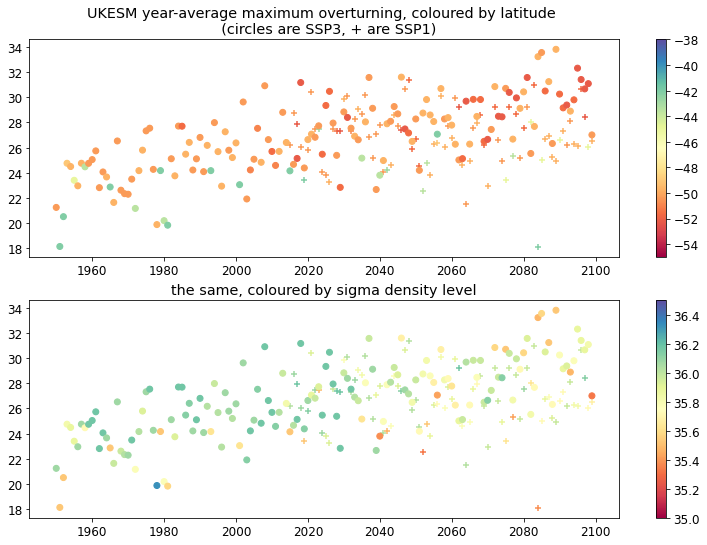

In [45]:
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = OT_1A.sel(time_counter=(OT_1A['time_counter.season'] == 'DJF')).\
    groupby('time_counter.year').mean()

q = axs[0].scatter(w.year, w.max_OT_yr,marker = '+',  c = w.lat_OT_yr, vmin = -55, vmax = -38, cmap = 'Spectral')
plt.colorbar(q, ax = axs[0])

q = axs[1].scatter(w.year, w.max_OT_yr, marker = '+', c = w.sigma2000_OT_yr, vmin = 35, vmax = 36.5, cmap = 'Spectral')
plt.colorbar(q, ax = axs[1])


w = OT_1B.sel(time_counter=(OT_1B['time_counter.season'] == 'DJF')).\
    groupby('time_counter.year').mean()

q = axs[0].scatter(w.year, w.max_OT_yr,marker = 'o',  c = w.lat_OT_yr, vmin = -55, vmax = -38, cmap = 'Spectral')
q = axs[1].scatter(w.year, w.max_OT_yr, marker = 'o', c = w.sigma2000_OT_yr, vmin = 35, vmax = 36.5, cmap = 'Spectral')

axs[0].set_title('UKESM year-average maximum overturning, coloured by latitude \n  (circles are SSP3, + are SSP1)' )
axs[1].set_title('the same, coloured by sigma density level')

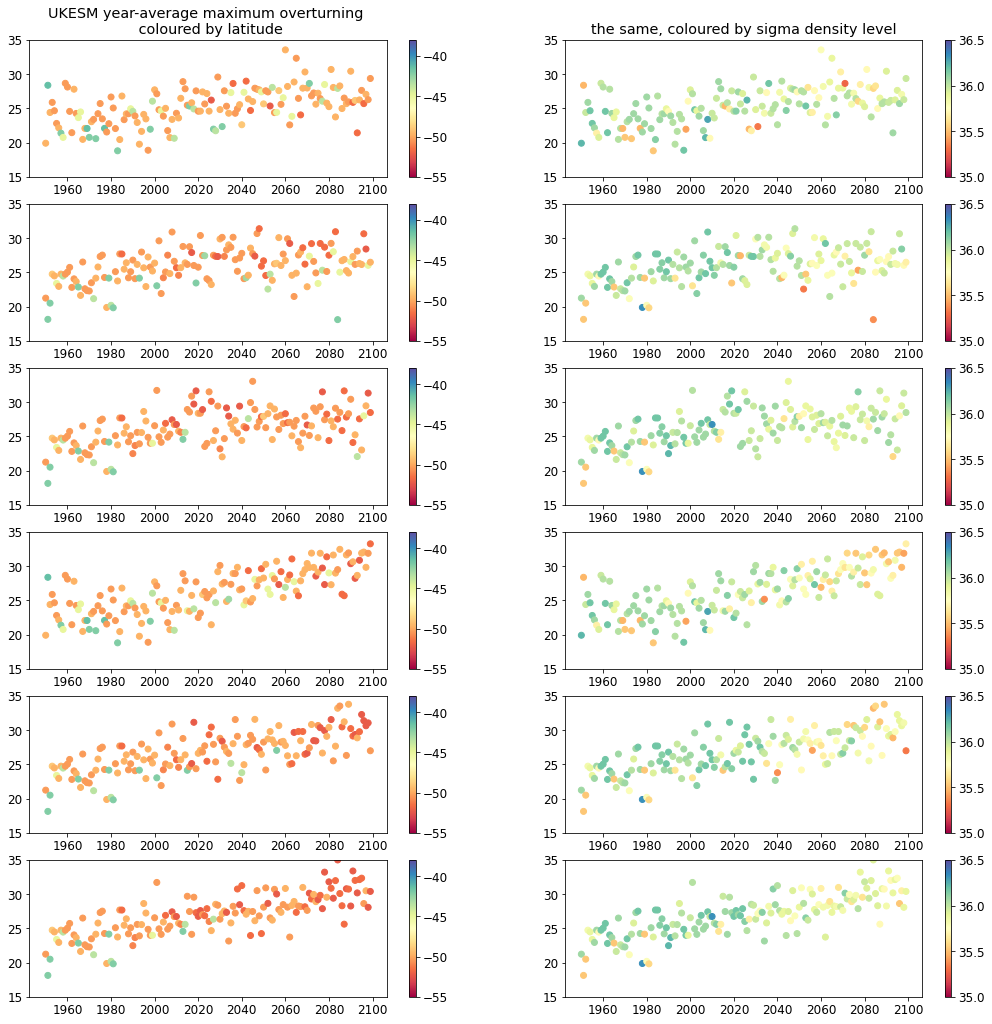

In [49]:
tl = [OT_2A, OT_1A, OT_3A, OT_2B, OT_1B, OT_3B]


fact = 1.1
fig, axs = plt.subplots(6,2, figsize=(16*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,6):
    
    OT = tl[i]
    

    w = OT.sel(time_counter=(OT['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean()

    q = axs[i*2].scatter(w.year, w.max_OT_yr,marker = 'o', \
                         c = w.lat_OT_yr, vmin = -55, vmax = -38, cmap = 'Spectral')
    plt.colorbar(q, ax = axs[i*2])

    q = axs[i*2+1].scatter(w.year, w.max_OT_yr, marker = 'o', c = w.sigma2000_OT_yr, vmin = 35, vmax = 36.5, cmap = 'Spectral')
    plt.colorbar(q, ax = axs[i*2+1])

axs[0].set_title('UKESM year-average maximum overturning \n coloured by latitude' )
axs[1].set_title('the same, coloured by sigma density level')

tyl = ['2A max OT (Sv)','2A max OT (Sv)',
      '1A ','1A ',
      '3A ','3A ',
      '2B ','2B ',
      '1B ','1B ',
      '3B ','3B ',
      ]

for i in range(0,12):
    axs[i].set_ylim([15,35])
    axs[i].set_ylim([15,35])